# Supervised Machine-Learning : XGBoost classifier for customer churn

We use continuous and categorical data from the **[IBM Base Samples](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=samples-telco-customer-churn)** to predict whether or not a customer will stop using a company's service. In business lingo, this is called Customer Churn.

**Raw data are stored in the `data` -> `raw` directory of the Git repository.**

**All scripts used to transform raw data into features for modeling and scripts for the model are located in the `feature` and `model directory`, but will be displayed in the notebook for all to see.**

**Variable documentation can be found in the `reference` directory.**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

In [2]:
column_documentation_file = '/Users/eudes/Documents/Portfolio/XGBoost_customer_churn/references/customer_churn_dict.txt'

def parse_column_documentation(file_path):
    """
    Parse column documentation from a text file and store it in a dictionary.

    Parameters:
    - file_path (str): The file path to the text file containing column documentation.

    Returns:
    - dict: A dictionary where keys are column names and values are their respective descriptions.
    """
    column_docs = {}
    with open(file_path, 'r') as doc_file:
        for line in doc_file:
            parts = line.strip().split(':')
            if len(parts) == 2:
                column_name = parts[0].strip()
                column_description = parts[1].strip()
                column_docs[column_name] = column_description
    return column_docs

def get_column_description(df, column_name):
    """
    Get the description of a specific column from the parsed column documentation.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the columns.
    - column_name (str): The name of the column for which you want to retrieve the description.

    Returns:
    - str: The description of the specified column. If no description is available, it returns "No documentation available."
    """
    if column_name in column_documentation:
        return column_documentation[column_name]
    else:
        return "No documentation available."


In [3]:
df = pd.read_csv(r'/Users/eudes/Documents/Portfolio/XGBoost_customer_churn/data/raw/Telco_customer_churn.csv')
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [4]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [5]:
column_documentation = parse_column_documentation(column_documentation_file)

Value_description = get_column_description(df, 'Churn Value')
Score_description = get_column_description(df, 'Churn Score')
CLTV_description = get_column_description(df, 'CLTV')
Reason_description = get_column_description(df, 'Churn Reason')

print(f"Churn Value Description: {Value_description}\n")
print(f"Churn Score Description: {Score_description}\n")
print(f"CLTV Description: {CLTV_description}\n")
print(f"Churn Reason Description: {Reason_description}\n")

Churn Value Description: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

Churn Score Description: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

CLTV Description: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

Churn Reason Description: A customer’s specific reason for leaving the company.



The last four variables contain exit interview information and should not be used for prediction, so we will remove them.

In [6]:
def delete_columns(df, columns_to_delete):
    """
    Delete specified columns from a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame from which columns will be deleted.
    columns_to_delete (list of str): A list of column names to be deleted from the DataFrame.

    Returns:
    DataFrame: A new DataFrame with the specified columns removed.
    """
    df = df.drop(columns=columns_to_delete)
    return df

In [7]:
df = delete_columns(df, ['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'])

In [8]:
len(df.columns)

29

In [9]:
df['Count'].unique() , df['Country'].unique() , df['State'].unique(), df['City'].unique()

(array([1]),
 array(['United States'], dtype=object),
 array(['California'], dtype=object),
 array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
        'Tulelake', 'Olympic Valley'], dtype=object))

We can omit those variables, except City because it contains a bunch of different city names, so we will leave it in.

We will also remove `Customer ID` because it is different for every customer and useless for classification. Lastly, we will drop `Lat Long` because there are separate columns for `Latitude` and `Longitude`.

In [10]:
df = delete_columns(df, ['CustomerID', 'Count', 'Country', 'State', 'Lat Long'])

In [11]:
len(df.columns)

24

**NOTE:** Although it is OK to have whitespace in the city names in **City** for **XGBoost** and classification, we can't have any whitespace if we want to draw a tree. So let's take care of that now by replacing the white space in the city names with an underscore character.

**ALSO NOTE** We can easily remove whitespaces from all values, not just city names, but we will wait to do that until after we have identified missing values.

In [12]:
def replace_spaces_with_underscores(df, column_name=None):
    """
    Replace spaces with underscores in a specific column of a DataFrame or in
    column names.

    This function can be used in two ways:
    1. If `column_name` is provided, it replaces all spaces in the specified
       column with underscores using regular expressions.
    2. If `column_name` is not provided, it replaces all spaces in column names
       with underscores.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to be processed.
    - column_name (str, optional): The name of the column in `df` where spaces
      should be replaced. If not provided, spaces in column names will be replaced.

    Returns:
    - DataFrame: A new DataFrame with spaces replaced by underscores in
      the specified column or in column names.
    """
    if column_name is not None:
        df[column_name] = df[column_name].replace(' ', '_', regex=True)
    else:
        df.columns = df.columns.str.replace(' ', '_')
    return df

In [13]:
df = replace_spaces_with_underscores(df, 'City')

In [14]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

We also need to eliminate the whitespace in the column names, so we'll replace it with underscores.

In [15]:
df = replace_spaces_with_underscores(df)

In [16]:
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

We have removed all of the data that will not help use create an XGBoost model. It's time to deal with missing Data

# Identifying Missing Data

XGBoost has default behavior for missing data, we have to identify missing values and make sure they are set to `0`

In [17]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [18]:
print(df.apply(lambda col: col.unique()))

City                 [Los_Angeles, Beverly_Hills, Huntington_Park, ...
Zip_Code             [90003, 90005, 90006, 90010, 90015, 90020, 900...
Latitude             [33.964131, 34.059281, 34.048013, 34.062125, 3...
Longitude            [-118.272783, -118.30742, -118.293953, -118.31...
Gender                                                  [Male, Female]
Senior_Citizen                                               [No, Yes]
Partner                                                      [No, Yes]
Dependents                                                   [No, Yes]
Tenure_Months        [2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...
Phone_Service                                                [Yes, No]
Multiple_Lines                             [No, Yes, No phone service]
Internet_Service                                [DSL, Fiber optic, No]
Online_Security                         [Yes, No, No internet service]
Online_Backup                           [Yes, No, No internet service]
Device

Two columns can cause troubles for us, Monthly/Total_Charges

In [19]:
df['Monthly_Charges'] = pd.to_numeric(df['Monthly_Charges'])

There are blank spaces, `" "`, in the Total_Charges column. So we need to deal with those.

In [20]:
len(df.loc[df['Total_Charges'] == ' '])

11

In [21]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We see that all **11** people with `Total_Charges == ' '` have just signed up, because **Tenure_Months** is `0`. These people also all have **Churn_Value** set to `0` because they just signed up. We can set **Total_Charges** to `0` for these **11** people or we can remove them. We will try setting **Total_Charges** to `0`.

In [22]:
def replace_empty_cells_with_value(df, column_name, replacement_value):
    """
    Replace empty cells in a specific column of a DataFrame with a specified value.

    Parameters:
    - df: The DataFrame to be processed.
    - column_name (str): The name of the column in `df` where empty cells should be replaced.
    - replacement_value: The value to replace empty cells with.

    Returns:
    - pandas.DataFrame: A new DataFrame with empty cells replaced by the specified value in
      the specified column.
    """
    df[column_name] = np.where(df[column_name] == ' ', replacement_value, df[column_name])
    return df

In [23]:
df = replace_empty_cells_with_value(df, 'Total_Charges', 0)

In [24]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


We modified **Total Charges** correctly by looking at everyone who had **Tenure Months** set to `0`.

In [25]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


**Total_Charges** still has the `object` data type but **XGBoost** only allows `int`, `float` or `boolean` data types. We have to converting it with `to_numeric()`.

In [26]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

**Data has been transformed, good pratice is to put the data into the `data/intermediate` directory**

In [27]:
df.to_csv(r'/Users/eudes/Documents/Portfolio/XGBoost_customer_churn/data/interim/processed_data.csv')

# Split the Data into Dependent and Independent Variables

# One-Hot Encoding

 The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **City** - **Category**
  - Los Angeles, Beverly Hills, etc.
- **Zip Code** - **Category**
  - 90003, 90005, etc.
- **Latitude** - **Float**
- **Longitude** - **Float**
- **Gender** - **Category**
  - Female, Male
- **Senior Citizen** - **Category**
  - Yes, No
- **Partner** - **Category**
  - Yes, No
- **Dependents** - **Category**
  - Yes, No
- **Tenure Months** - **Float**
- **Phone Service** - **Category**
  - Yes, No
- **Multiple Lines** - **Category**
  - Yes, No
- **Internet Service** - **Category**
  - No, DSL, Fiber optic
- **Online Security** - **Category**
  - Yes, No
- **Online Backup** - **Category**
  - Yes, No
- **Device Protection** - **Category**
  - Yes, No
- **Tech Support** - **Category**
  - Yes, No
- **Streaming TV** - **Category**
  - Yes, No
- **Streaming Movies** - **Category**
  - Yes, No
- **Contract** - **Category**
  - Month-to-month, One year, Two year
- **Paperless Billing** - **Category**
  - Yes, No
- **Payment Method** - **Category**
  - Mailed check, Electronic check, etc...
- **Monthly Charges** - **Float**
- **Total Charges** - **Float**


let's look at the data types in `X` to remember how python is seeing the data right now.

In [28]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

**Latitude**, **Longitude**, **Monthly_Charges** and **Total_Charges** are all `float64`, we want them to be floating point numbers so it's good. However, all of the columns that are `object` type need to be inspected to make sure they only contain reasonable values. Because, while XGBoost natively supports continuous data, like **Monthly_Charges** and **Total_Charges**, it does not natively support categorical data, like **Phone_Service**, which contains 2 different categories. In order to use categorical data with XGBoost.

In [29]:
categorical_columns = ['City','Gender', 'Senior_Citizen', 'Partner',
                       'Dependents', 'Phone_Service', 'Multiple_Lines',
                       'Internet_Service', 'Online_Security', 'Online_Backup',
                       'Device_Protection', 'Tech_Support', 'Streaming_TV',
                       'Streaming_Movies', 'Contract', 'Paperless_Billing',
                       'Payment_Method']

In [30]:
def prepare_features_target(df, target_column, categorical_columns=[]):
    """
    Prepare features and target variables.

    Parameters:
    - df: The DataFrame containing the data.
    - target_column (str): The name of the target variable column.
    - categorical_columns (list): List of column names to be one-hot encoded (if applicable).

    Returns:
    - DataFrame: Features DataFrame with one-hot encoding applied to
      specified categorical columns.
    - Series: Target variable Series.
    """
    # Create features DataFrame by dropping the target column
    X = df.drop(target_column, axis=1).copy()

    # Create the target variable Series
    y = df[target_column].copy()

    # Check if categorical_columns is not empty and apply one-hot encoding
    if categorical_columns:
        X = pd.get_dummies(X, columns=categorical_columns)
        return X, y
    else:
        return X, y

In [31]:
X_encoded, y = prepare_features_target(df, 'Churn_Value', categorical_columns = categorical_columns)

In [32]:
X_encoded.columns
X_encoded = replace_spaces_with_underscores(X_encoded)

In [33]:
X_encoded.columns

Index(['Zip_Code', 'Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges',
       'Total_Charges', 'City_Acampo', 'City_Acton', 'City_Adelanto',
       'City_Adin',
       ...
       'Streaming_Movies_Yes', 'Contract_Month-to-month', 'Contract_One_year',
       'Contract_Two_year', 'Paperless_Billing_No', 'Paperless_Billing_Yes',
       'Payment_Method_Bank_transfer_(automatic)',
       'Payment_Method_Credit_card_(automatic)',
       'Payment_Method_Electronic_check', 'Payment_Method_Mailed_check'],
      dtype='object', length=1178)

Let's verify that `y` only contains **1s** and **0s**

In [34]:
y.unique()

array([1, 0])

We have to check one more thing before digging into the model itself: The balance of the data

In [35]:
int((sum(y)/len(y))*100)

26

only **26%** of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the **training** set and the **testing** set.

In [36]:
def split_data(X, y, test_size=None, random_state=None, stratify=None):
    """
    Split the data into training and testing sets.

    Parameters:
    - X (pandas.DataFrame or numpy.ndarray): The feature matrix.
    - y (pandas.Series or numpy.ndarray): The target variable.
    - test_size (float or int, optional): The proportion of the dataset to include in
      the test split.
    - random_state (int or None, optional): Seed for random number generation (default is None).
    - stratify (array-like, optional): If not None, it ensures that the class distribution
      of the target variable is approximately the same in the training and testing sets.

    Returns:
    - tuple: A tuple containing X_train, X_test, y_train, and y_test.

    Example:
    To split the data into training and testing sets with a test size of 0.2 and a
    random state of 42:

    >>> X_train, X_test, y_train, y_test = split_data(X_encoded, y, test_size=0.2, random_state=42)
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify)
    
    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test = split_data(X_encoded, y, random_state=42, stratify=y)

In [38]:
sum(y_train)/len(y_train)

0.2654297614539947

In [39]:
sum(y_test)/len(y_test)

0.26519023282226006

# Preliminary XGBoost Model

In [40]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric="logloss",
                            seed=42,
                            early_stopping_rounds=10) #stop building trees when they no longer improve the situation)

clf_xgb.fit(X_train,
            y_train,
            verbose=2,
            eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.50237
[2]	validation_0-logloss:0.43913
[4]	validation_0-logloss:0.41643
[6]	validation_0-logloss:0.40841
[8]	validation_0-logloss:0.40429
[10]	validation_0-logloss:0.40469
[12]	validation_0-logloss:0.40357
[14]	validation_0-logloss:0.40476
[16]	validation_0-logloss:0.40480
[18]	validation_0-logloss:0.40612
[20]	validation_0-logloss:0.40665
[22]	validation_0-logloss:0.40721


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Let's see how it performs on the testing Dataset by running the testing Dataset down the model and drawing a Confusion Matrix.

Text(0.5, 1.0, 'Normalized confusion matrix')

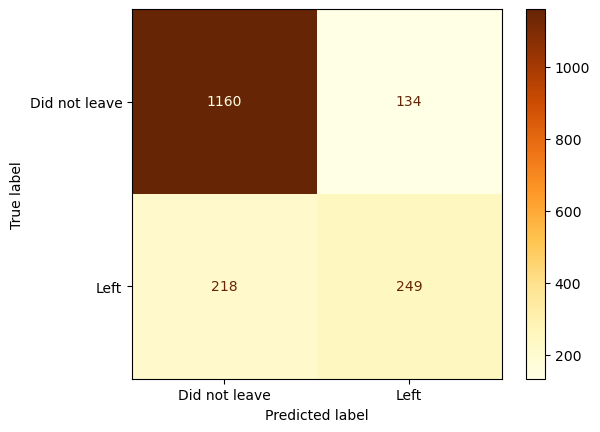

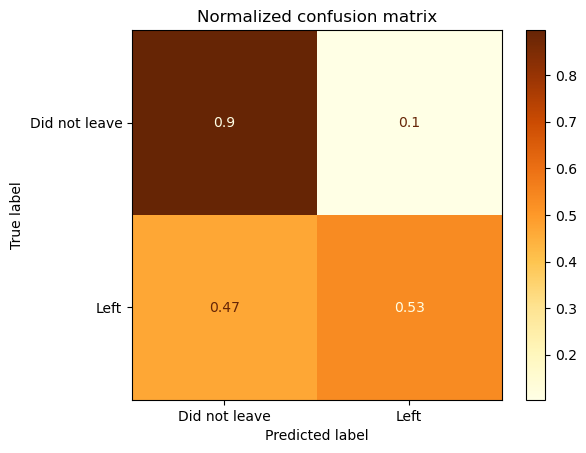

In [41]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=["Did not leave", "Left"],
        cmap=plt.cm.YlOrBr,
        normalize=normalize,
    )
disp.ax_.set_title(title)

We see that of the **1294** people that **did not leave**, **1160 (90%)** were correctly classified. And of the **467** people that **left the company**, **249 (53%)** were correctly classified. The XGBoost model was not really great. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing **1294** people that did not default and the bottom row showing **467** people who did. Because people leaving costs the company a lot of money, we would like to capture more of the people that left.

# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

# Optimize Parameters using Cross Validation and GridSearch()

XGBoost has a parameter, `scale_pos_weight`, that helps with imbalanced data. So let's try to improve predictions using Cross Validation to optimize the parameters.

In [42]:
def train_model(X, y):
    """
    Train the machine learning model using cross-validation and grid search.

    Parameters:
    X (DataFrame): Features (input variables) for training.
    y (Series): Target variable for training.

    Returns:
    XGBoostClassifier: The best-trained XGBoost model found by grid search.
    """
    # Define the machine learning model
    model = xgb.XGBClassifier(objective='binary:logistic',
                                 eval_metric="logloss",
                                 seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 early_stopping_rounds=10)

    # Define hyperparameters for grid search
    param_grid = {'max_depth': [4],
              'learning_rate': [0.1, 0.5, 1],
              'gamma': [0.25],
              'reg_lambda': [10, 20, 100],
              'scale_pos_weight': [3]
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid,
                                 scoring='roc_auc',
                                 verbose=1,
                                 n_jobs = 10,
                                 cv = 3)
    grid_search.fit(X,
                    y,
                    eval_set=[(X_test, y_test)],
                    verbose=True)

    # Print the best hyperparameters
    print("Best Hyperparameters:", grid_search.best_params_)
    

    return grid_search.best_estimator_

In [43]:
hist = train_model(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-logloss:0.68091
[1]	validation_0-logloss:0.65397
[0]	validation_0-logloss:0.68026
[2]	validation_0-logloss:0.63277
[3]	validation_0-logloss:0.61198
[1]	validation_0-logloss:0.65228
[4]	validation_0-logloss:0.59677
[2]	validation_0-logloss:0.63158
[3]	validation_0-logloss:0.61200
[5]	validation_0-logloss:0.58310
[6]	validation_0-logloss:0.57054
[4]	validation_0-logloss:0.59680
[7]	validation_0-logloss:0.55942
[5]	validation_0-logloss:0.58372
[0]	validation_0-logloss:0.68060
[0]	validation_0-logloss:0.68220
[8]	validation_0-logloss:0.54967
[0]	validation_0-logloss:0.68223
[6]	validation_0-logloss:0.57229
[0]	validation_0-logloss:0.68856
[0]	validation_0-logloss:0.68169
[1]	validation_0-logloss:0.65283
[0]	validation_0-logloss:0.68982
[0]	validation_0-logloss:0.68859
[1]	validation_0-logloss:0.65618
[9]	validation_0-logloss:0.54093
[1]	validation_0-logloss:0.65672
[7]	validation_0-logloss:0.56126
[1]	validation_0

[26]	validation_0-logloss:0.48065
[26]	validation_0-logloss:0.48277
[34]	validation_0-logloss:0.46958
[26]	validation_0-logloss:0.51049
[26]	validation_0-logloss:0.51640
[32]	validation_0-logloss:0.48234
[26]	validation_0-logloss:0.49484
[26]	validation_0-logloss:0.48505
[26]	validation_0-logloss:0.51015
[27]	validation_0-logloss:0.47938
[27]	validation_0-logloss:0.48135
[35]	validation_0-logloss:0.46871
[27]	validation_0-logloss:0.50811
[27]	validation_0-logloss:0.51451
[27]	validation_0-logloss:0.48333
[33]	validation_0-logloss:0.48172
[27]	validation_0-logloss:0.49357
[27]	validation_0-logloss:0.50800
[28]	validation_0-logloss:0.47819
[36]	validation_0-logloss:0.46858
[28]	validation_0-logloss:0.48004
[28]	validation_0-logloss:0.51269
[28]	validation_0-logloss:0.50623
[34]	validation_0-logloss:0.48042
[28]	validation_0-logloss:0.48197
[28]	validation_0-logloss:0.49224
[28]	validation_0-logloss:0.50599
[29]	validation_0-logloss:0.47626
[29]	validation_0-logloss:0.51073
[37]	validatio

[61]	validation_0-logloss:0.45968
[53]	validation_0-logloss:0.46812
[53]	validation_0-logloss:0.48174
[53]	validation_0-logloss:0.49365
[54]	validation_0-logloss:0.46499
[53]	validation_0-logloss:0.46604
[59]	validation_0-logloss:0.47150
[53]	validation_0-logloss:0.48311
[53]	validation_0-logloss:0.47851
[62]	validation_0-logloss:0.45924
[54]	validation_0-logloss:0.46827
[54]	validation_0-logloss:0.49350
[54]	validation_0-logloss:0.46589
[54]	validation_0-logloss:0.48164
[55]	validation_0-logloss:0.46446
[60]	validation_0-logloss:0.47124
[54]	validation_0-logloss:0.47829
[54]	validation_0-logloss:0.48291
[63]	validation_0-logloss:0.45861
[55]	validation_0-logloss:0.46822
[55]	validation_0-logloss:0.49375
[55]	validation_0-logloss:0.46557
[55]	validation_0-logloss:0.48108
[61]	validation_0-logloss:0.47075
[56]	validation_0-logloss:0.46463
[55]	validation_0-logloss:0.47830
[55]	validation_0-logloss:0.48253
[64]	validation_0-logloss:0.45851
[56]	validation_0-logloss:0.46833
[56]	validatio

[80]	validation_0-logloss:0.45944
[80]	validation_0-logloss:0.47391
[87]	validation_0-logloss:0.46874
[80]	validation_0-logloss:0.47253
[80]	validation_0-logloss:0.48493
[81]	validation_0-logloss:0.46267
[82]	validation_0-logloss:0.45978
[89]	validation_0-logloss:0.45549
[80]	validation_0-logloss:0.47151
[81]	validation_0-logloss:0.45964
[81]	validation_0-logloss:0.47368
[81]	validation_0-logloss:0.48455
[81]	validation_0-logloss:0.47240
[82]	validation_0-logloss:0.46213
[83]	validation_0-logloss:0.46012
[90]	validation_0-logloss:0.45538
[88]	validation_0-logloss:0.46842
[81]	validation_0-logloss:0.47110
[82]	validation_0-logloss:0.45899
[82]	validation_0-logloss:0.47358
[82]	validation_0-logloss:0.48411
[83]	validation_0-logloss:0.46241
[82]	validation_0-logloss:0.47155
[89]	validation_0-logloss:0.46848
[84]	validation_0-logloss:0.46001
[82]	validation_0-logloss:0.47065
[91]	validation_0-logloss:0.45538
[83]	validation_0-logloss:0.45887
[83]	validation_0-logloss:0.47331
[84]	validatio

[8]	validation_0-logloss:0.48566
[8]	validation_0-logloss:0.49047
[7]	validation_0-logloss:0.48777
[16]	validation_0-logloss:0.48065
[18]	validation_0-logloss:0.47437
[15]	validation_0-logloss:0.47276
[8]	validation_0-logloss:0.49014
[7]	validation_0-logloss:0.49849
[16]	validation_0-logloss:0.46335
[9]	validation_0-logloss:0.48295
[0]	validation_0-logloss:0.58824
[9]	validation_0-logloss:0.48586
[19]	validation_0-logloss:0.47283
[16]	validation_0-logloss:0.47285
[17]	validation_0-logloss:0.47833
[8]	validation_0-logloss:0.48904
[9]	validation_0-logloss:0.48309
[8]	validation_0-logloss:0.49908
[17]	validation_0-logloss:0.46186
[10]	validation_0-logloss:0.48172
[20]	validation_0-logloss:0.47126
[10]	validation_0-logloss:0.48306
[1]	validation_0-logloss:0.53508
[17]	validation_0-logloss:0.46960
[18]	validation_0-logloss:0.47846
[9]	validation_0-logloss:0.49495
[10]	validation_0-logloss:0.48286
[9]	validation_0-logloss:0.49284
[18]	validation_0-logloss:0.46158
[11]	validation_0-logloss:0.

[8]	validation_0-logloss:0.48568
[6]	validation_0-logloss:0.49338
[12]	validation_0-logloss:0.48678
[6]	validation_0-logloss:0.49436
[9]	validation_0-logloss:0.48277
[13]	validation_0-logloss:0.48713
[7]	validation_0-logloss:0.49219
[7]	validation_0-logloss:0.49868
[10]	validation_0-logloss:0.48539
[14]	validation_0-logloss:0.49224
[8]	validation_0-logloss:0.49350
[8]	validation_0-logloss:0.49627
[11]	validation_0-logloss:0.48250
[9]	validation_0-logloss:0.48762
[9]	validation_0-logloss:0.49365
[15]	validation_0-logloss:0.50098
[12]	validation_0-logloss:0.48157
[0]	validation_0-logloss:0.57697
[0]	validation_0-logloss:0.55939
[16]	validation_0-logloss:0.49784
[10]	validation_0-logloss:0.49265
[10]	validation_0-logloss:0.49604
[0]	validation_0-logloss:0.56005
[1]	validation_0-logloss:0.51988
[13]	validation_0-logloss:0.48520
[1]	validation_0-logloss:0.52407
[17]	validation_0-logloss:0.49354
[11]	validation_0-logloss:0.49774
[11]	validation_0-logloss:0.49876
[1]	validation_0-logloss:0.52

Corresponding to the Cross-Validation results,  `gamma=0.25`, `learn_rate=0.1`, `max_depth=4`, and `reg_lambda=100` was the best parameters.

Text(0.5, 1.0, 'Normalized confusion matrix')

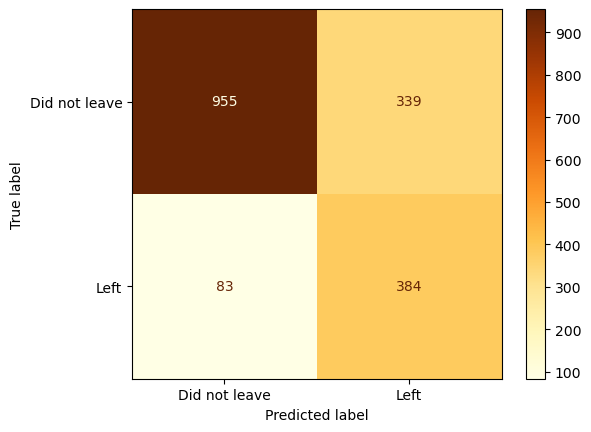

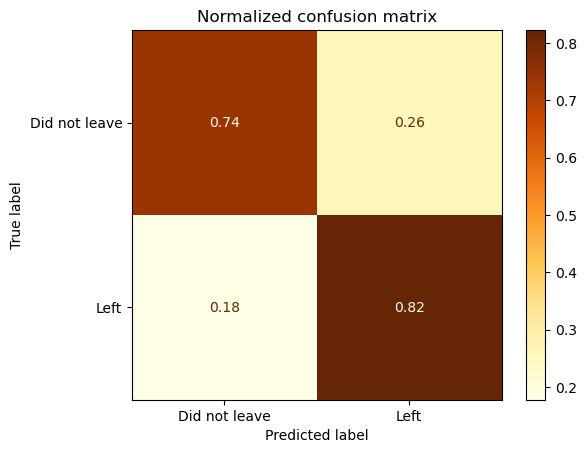

In [44]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        hist,
        X_test,
        y_test,
        display_labels=["Did not leave", "Left"],
        cmap=plt.cm.YlOrBr,
        normalize=normalize,
    )

disp.ax_.set_title(title)

The optimized XGBoost model is a lot better at identifying people that left the company. Of the **467** people that left the company, **384 (82%)**, were correctly identified. Before optimization, we only correctly identified **253 (54%)**. However, this improvement was at the expense of not being able to correctly classify as many people that did not leave. Before optimization, we correctly identified **1160 (90%)** people that did not leave. Now we only correctly classify **955 (74%)**. It's all about trade-off between recall and precision, but this trade off **may be better for the company** because now it can focus resources on the people that leave if that will help them retain them.

#### Finally, we save our model in the `models` section of the Git repository.

In [50]:
model_file_path = '/Users/eudes/Documents/Portfolio/XGBoost_customer_churn/models/XGBoost_model.xgb'

hist.save_model(model_file_path)

print(f"Model saved to '{model_file_path}'")

Model saved to '/Users/eudes/Documents/Portfolio/XGBoost_customer_churn/models/XGBoost_model.xgb'


## Extra : Shap of the model

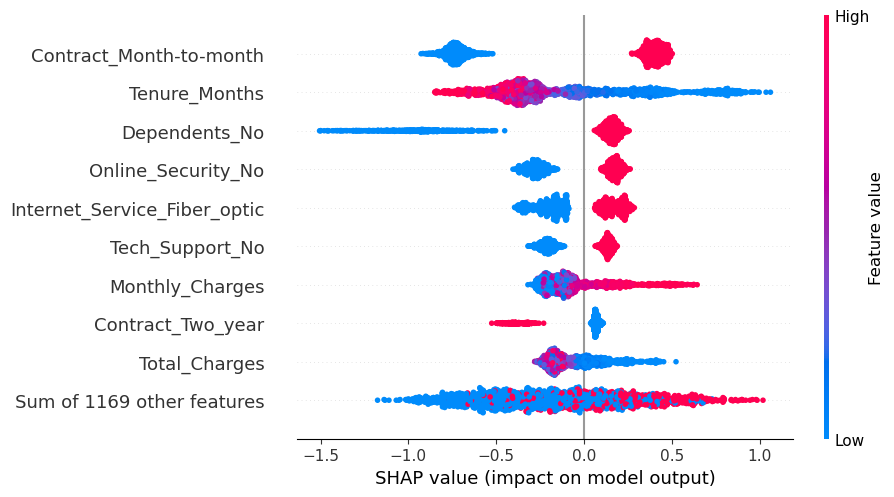

In [45]:
explainer = shap.Explainer(hist)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

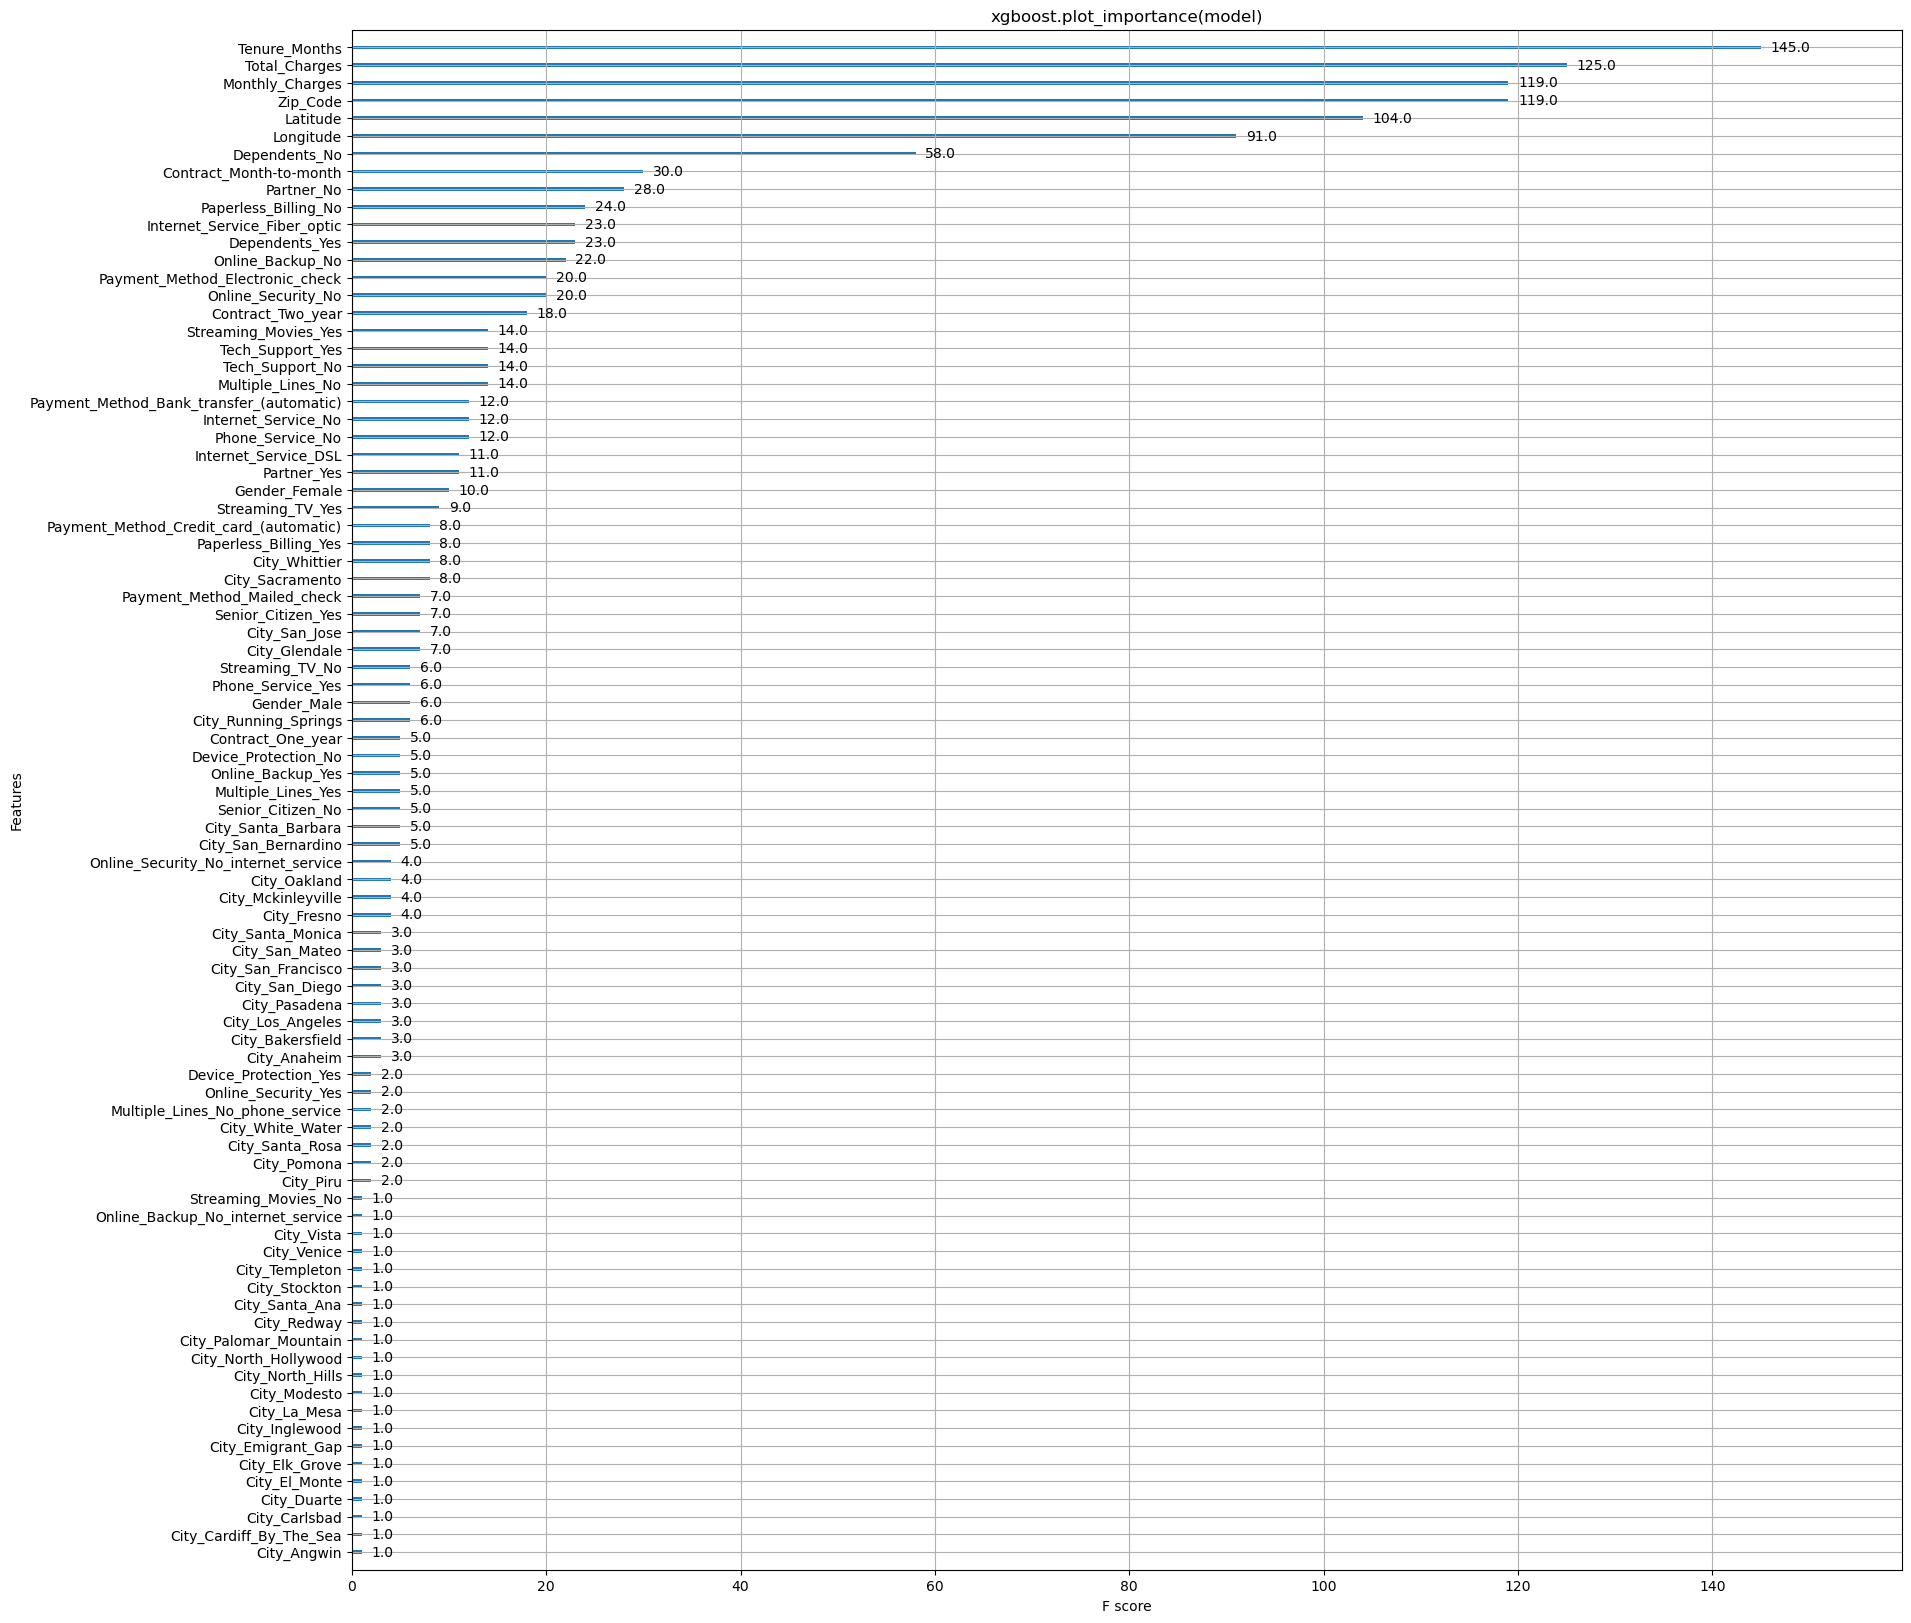

In [52]:
xgb.plot_importance(hist)
plt.rcParams["figure.figsize"]=(20, 20)
plt.title("xgboost.plot_importance(model)")
plt.show()